# Map between two states and get free energy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.7

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.7


In [3]:
import jax
import equinox as eqx
import logging
import git
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from dataclasses import asdict
from typing import cast

from rigid_flows.data import DataWithAuxiliary
from rigid_flows.density import KeyArray, OpenMMDensity
from rigid_flows.flow import (
    RigidWithAuxiliary,
    build_flow,
    initialize_actnorm,
    toggle_layer_stack,
)
from rigid_flows.reporting import Reporter, pretty_json
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.train import run_training_stage

from flox._src.flow.api import Transform
# from flox._src.flow.sampling import PushforwardSampler, PullbackSampler
from flox.flow import Pipe
from flox.util import key_chain


2023-01-13 06:59:32.028040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-13 06:59:32.028127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-13 06:59:32.028134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
logging.getLogger().setLevel(logging.INFO)

def setup_model(key: KeyArray, specs: ExperimentSpecification):
    chain = key_chain(key)

    print("Loading base density.")
    base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)

    print(f"Loading target density.")
    target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)
    target.com_model = base.com_model # there is no reason to have different com distribution

    print(f"Setting up flow model.")
    flow = build_flow(
        next(chain),
        specs.model.auxiliary_shape,
        specs.model.flow,
        base,
        # target,
    )
    
    # print(f"Initializing ActNorm")

    # @eqx.filter_jit
    # def init_actnorm(flow, key):
    #     actnorm_batch = jax.vmap(target.sample)(
    #         jax.random.split(key, specs.act_norm_init_samples)
    #     ).obj
    #     flow = toggle_layer_stack(flow, False)
    #     flow, _ = initialize_actnorm(flow, actnorm_batch)
    #     flow = toggle_layer_stack(flow, True)
    #     return flow

    # flow = init_actnorm(flow, next(chain))

    if specs.model.pretrained_model_path is not None:
        print(f"Loading pre-trained model from {specs.model.pretrained_model_path}.")
        flow = cast(
            Pipe[DataWithAuxiliary, RigidWithAuxiliary],
            eqx.tree_deserialise_leaves(specs.model.pretrained_model_path, flow),
        )

    return base, target, flow


def train(
    key: KeyArray,
    run_dir: str,
    specs: ExperimentSpecification,
    base: OpenMMDensity,
    target: OpenMMDensity,
    flow: Transform[DataWithAuxiliary, DataWithAuxiliary],
    tot_iter: int,
    loss_reporter: list,
) -> Transform[DataWithAuxiliary, DataWithAuxiliary]:
    chain = key_chain(key)
    # repo = git.Repo(search_parent_directories=True)
    # branch = repo.active_branch.name
    # sha = repo.head.object.hexsha

    # log = asdict(specs)
    # log["git"] = {"branch": branch, "sha": sha}
    # tf.summary.text("run_params", pretty_json(log), step=tot_iter)
    print(f"Starting training.")
    reporter = Reporter(
        base,
        target,
        run_dir,
        specs.reporting,
        scope=None,
    )
    reporter.with_scope(f"initial").report_model(next(chain), flow, tot_iter)
    for stage, train_spec in enumerate(specs.train):
        flow = run_training_stage(
            next(chain),
            base,
            target,
            flow,
            train_spec,
            specs.model.target,
            reporter.with_scope(f"training_stage_{stage}"),
            tot_iter,
            loss_reporter,
        )
        tot_iter += train_spec.num_iterations
    return flow


In [5]:
specs_file = "testing.yaml"
specs = ExperimentSpecification.load_from_file(specs_file)

chain = key_chain(specs.seed)
base, target, flow = setup_model(next(chain), specs)
model = base.omm_model.model

tot_iter = specs.global_step if specs.global_step is not None else 0


INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T250_N16.json


Loading base density.


INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T250_N16.npz
INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T100_N16.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T100_N16.npz


Loading target density.
Setting up flow model.


In [6]:
num_samples = 5_000
keys = jax.random.split(next(chain), num_samples)
base_tr = jax.vmap(base.sample)(keys)

keys = jax.random.split(next(chain), num_samples)
target_tr = jax.vmap(target.sample)(keys)

mapped_tr = jax.vmap(flow.inverse)(base_tr.obj)

In [7]:
from rigid_flows.flow import to_rigid

k = 0
base_k_oxy = jax.vmap(to_rigid)(base_tr.obj.pos[:, k]).obj
target_k_oxy = jax.vmap(to_rigid)(target_tr.obj.pos[:, k]).obj
# mapped_k_oxy = jax.vmap(to_rigid)(mapped_tr.obj.pos[:, k]).obj

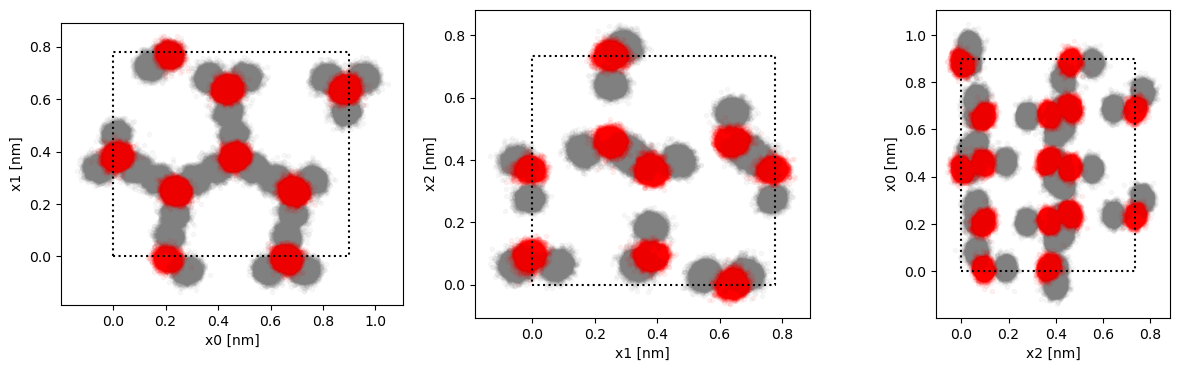

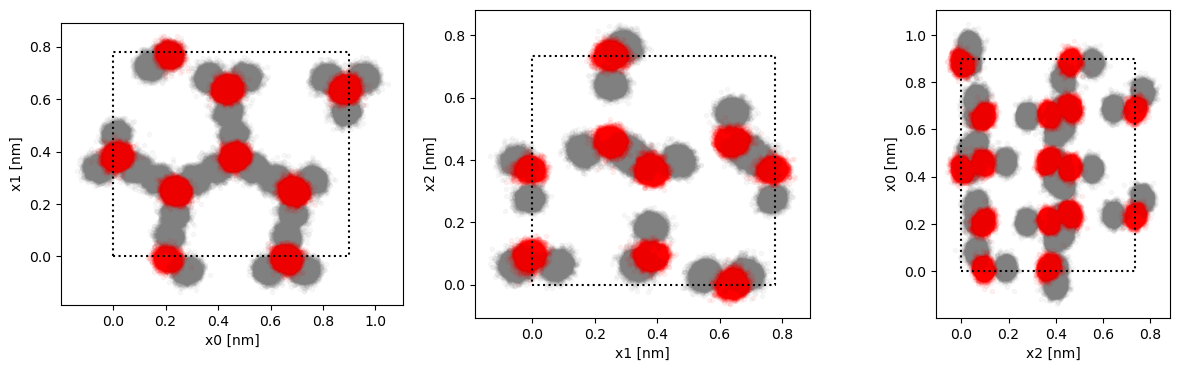

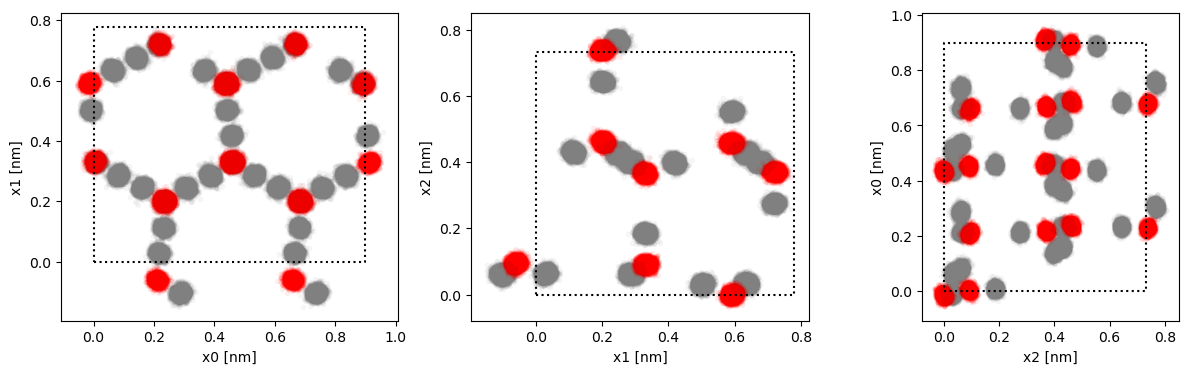

In [8]:
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))


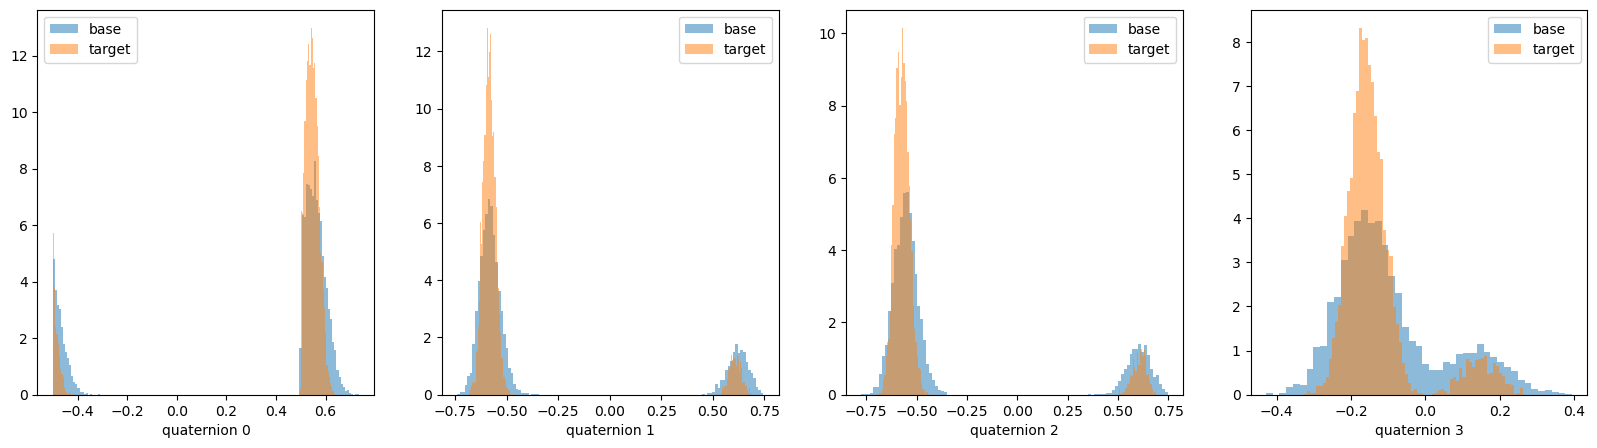

In [9]:
hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    plt.hist(base_k_oxy.rot[:, i], **hist_kwargs, label="base")
    plt.hist(target_k_oxy.rot[:, i], **hist_kwargs, label="target")
    plt.xlabel(f"quaternion {i}")
    plt.legend()
plt.show()


In [10]:
def normalize_quats(quats, ref):
    sign = np.sign(np.sum(quats * ref[None], axis=-1, keepdims=True))
    quats = quats * sign
    return quats


unsigned_base = normalize_quats(base_k_oxy.rot, base_k_oxy.rot[0])
unsigned_target = normalize_quats(target_k_oxy.rot, target_k_oxy.rot[0])


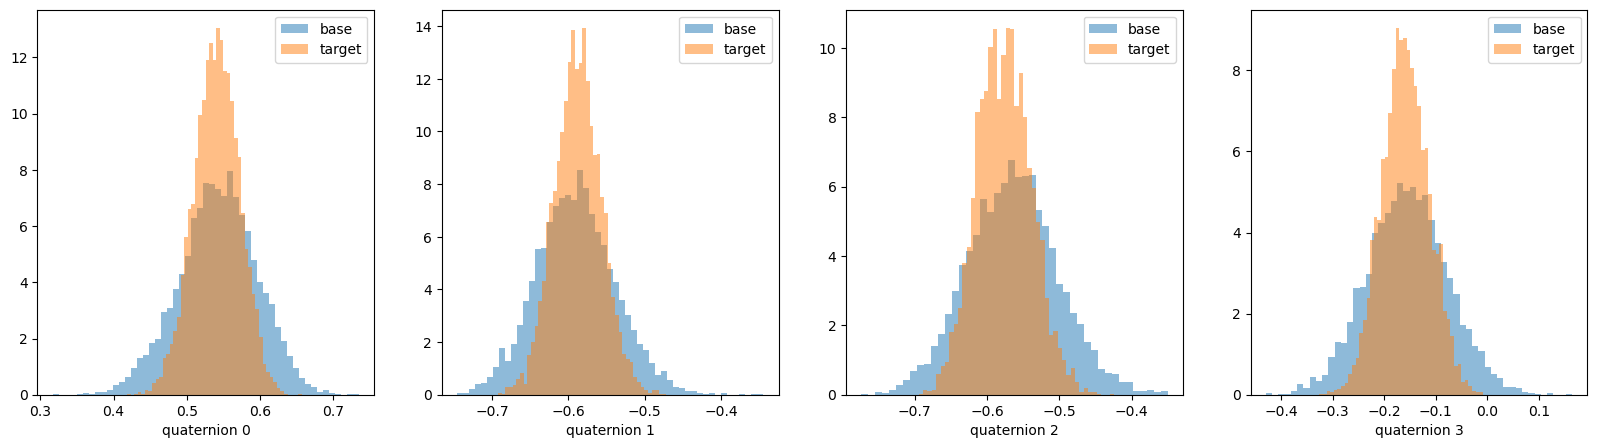

In [11]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    plt.hist(unsigned_base[:, i], **hist_kwargs, label="base")
    plt.hist(unsigned_target[:, i], **hist_kwargs, label="target")
    plt.xlabel(f"quaternion {i}")
    plt.legend()
plt.show()


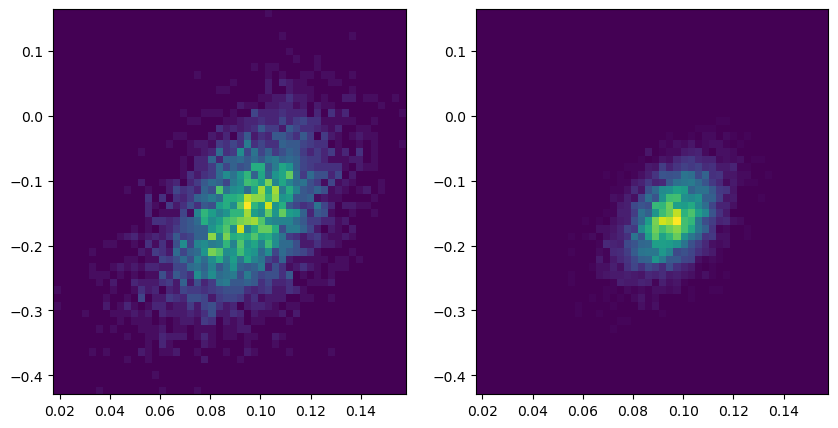

In [12]:
i = 2
j = 3
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
_, xbins, ybins, _ = plt.hist2d(base_k_oxy.pos[:, i], unsigned_base[:, j], bins=50)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 2, 2)
plt.hist2d(target_k_oxy.pos[:, i], unsigned_target[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.show()


INFO:root:preparing report
INFO:root:sampling from data


Starting training.


INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/initial
INFO:root:plotting quaternions
INFO:root:plotting oxygens
INFO:root:reporting ESS = 5.181687831878662
INFO:root:plotting energy histogram
Epoch: 1/2: 100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s, loss=-642.43274]
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_0
INFO:root:plotting quaternions
INFO:root:plotting oxygens
INFO:root:reporting ESS = 1.0925418138504028
INFO:root:plotting energy histogram
Epoch: 2/2: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s, loss=-642.9098]
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_1
INFO:root:plotting quaternions
INFO:root:plotting oxygens
INFO:root:reporting ESS = 4.155237197875

<Figure size 640x480 with 0 Axes>

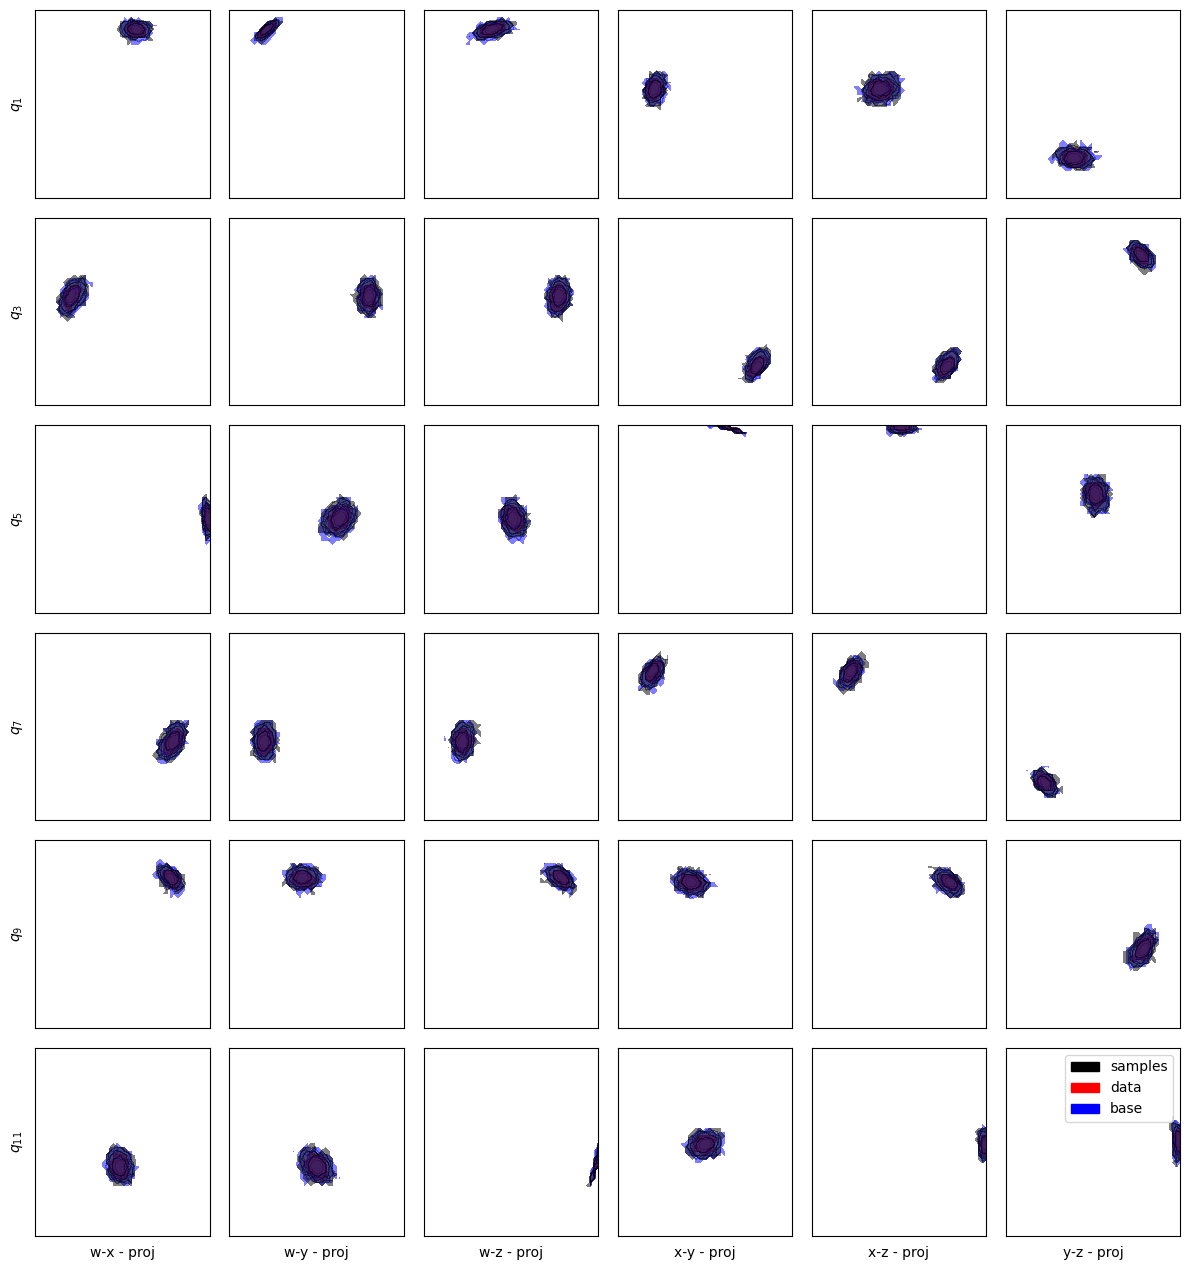

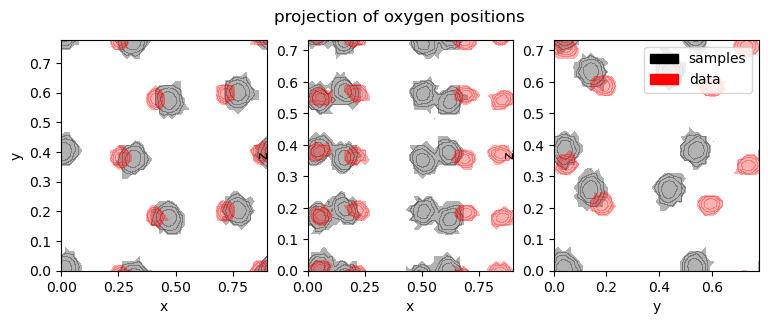

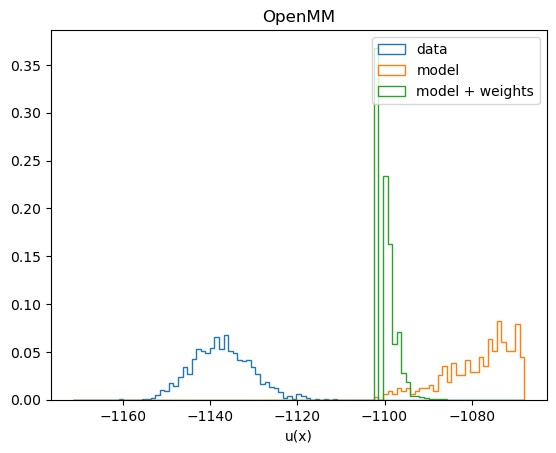

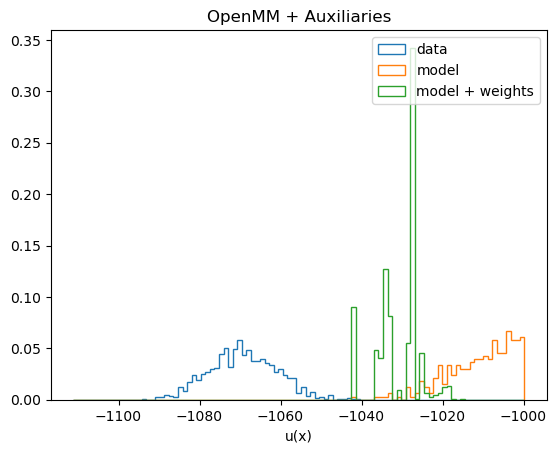

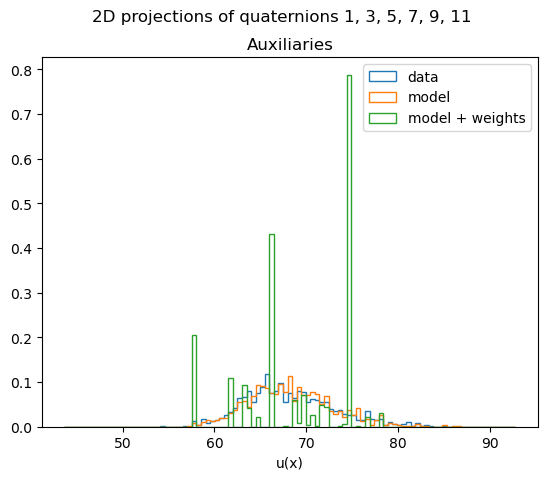

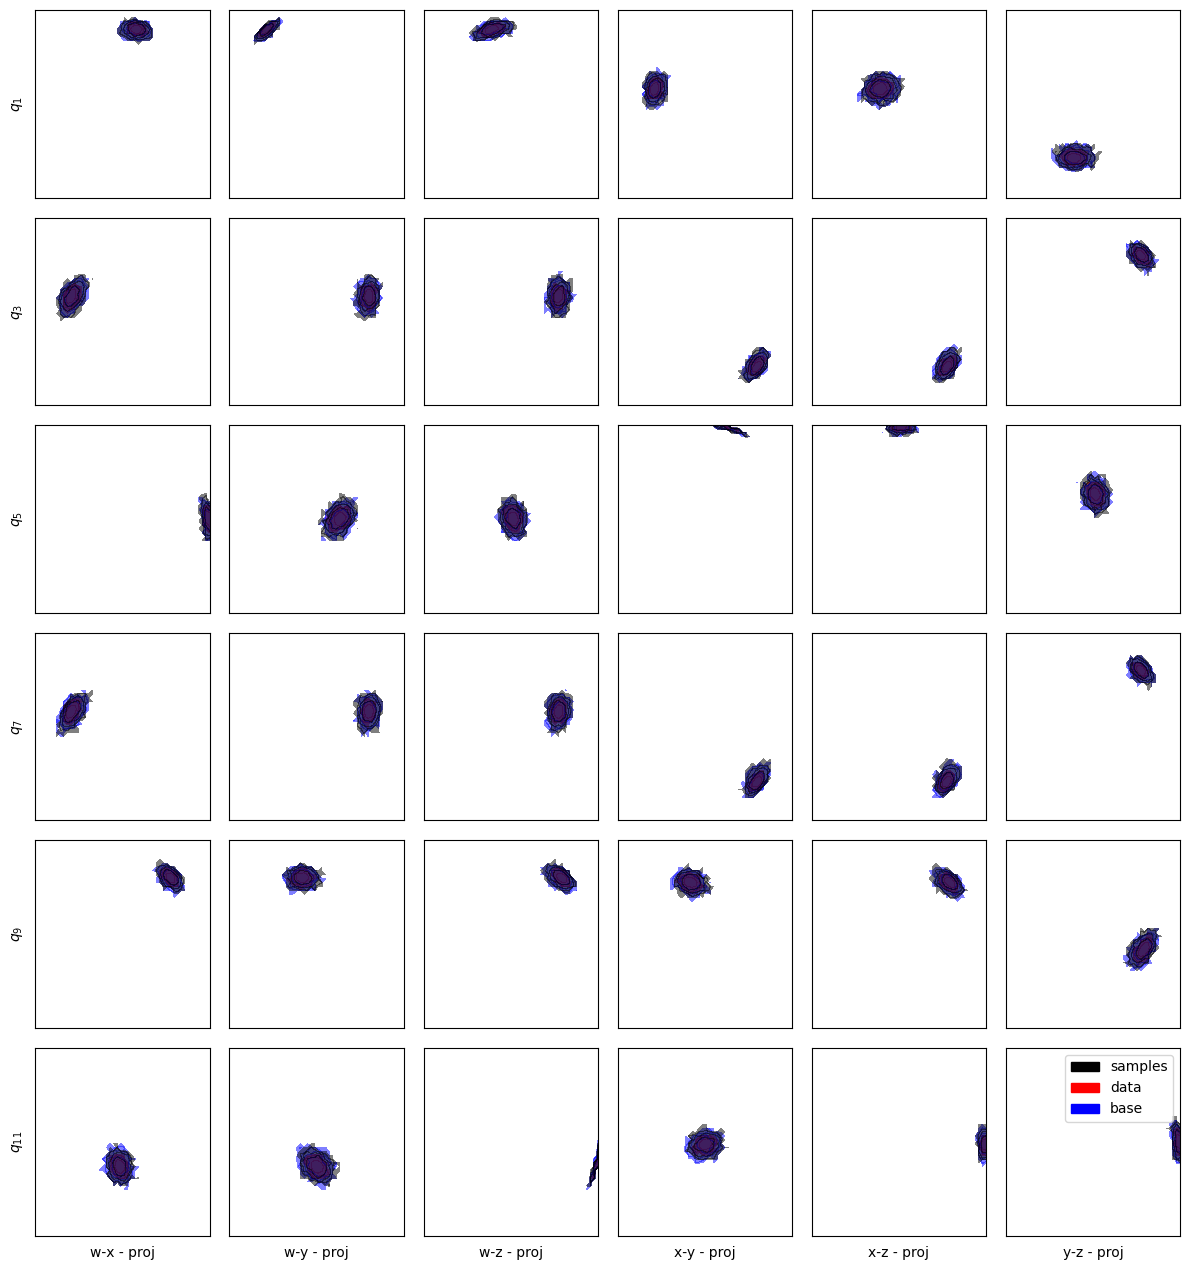

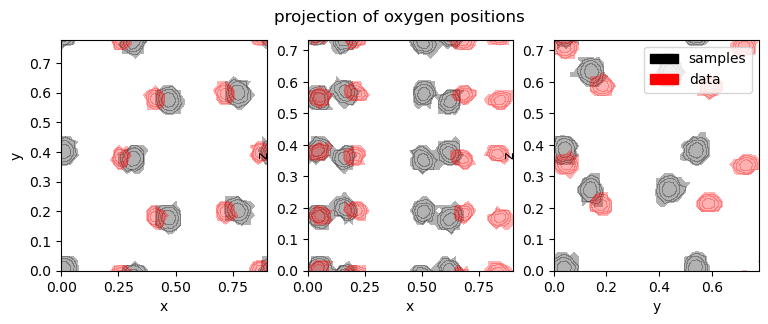

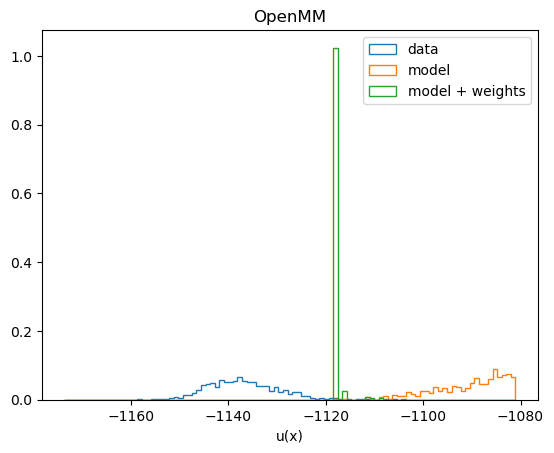

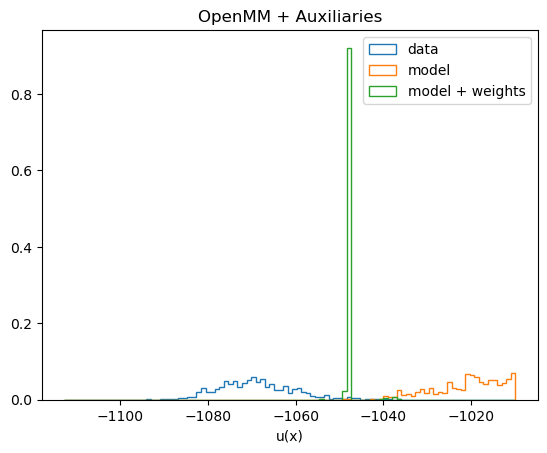

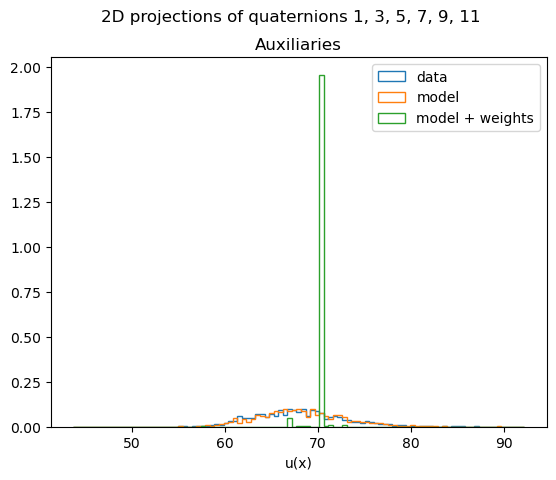

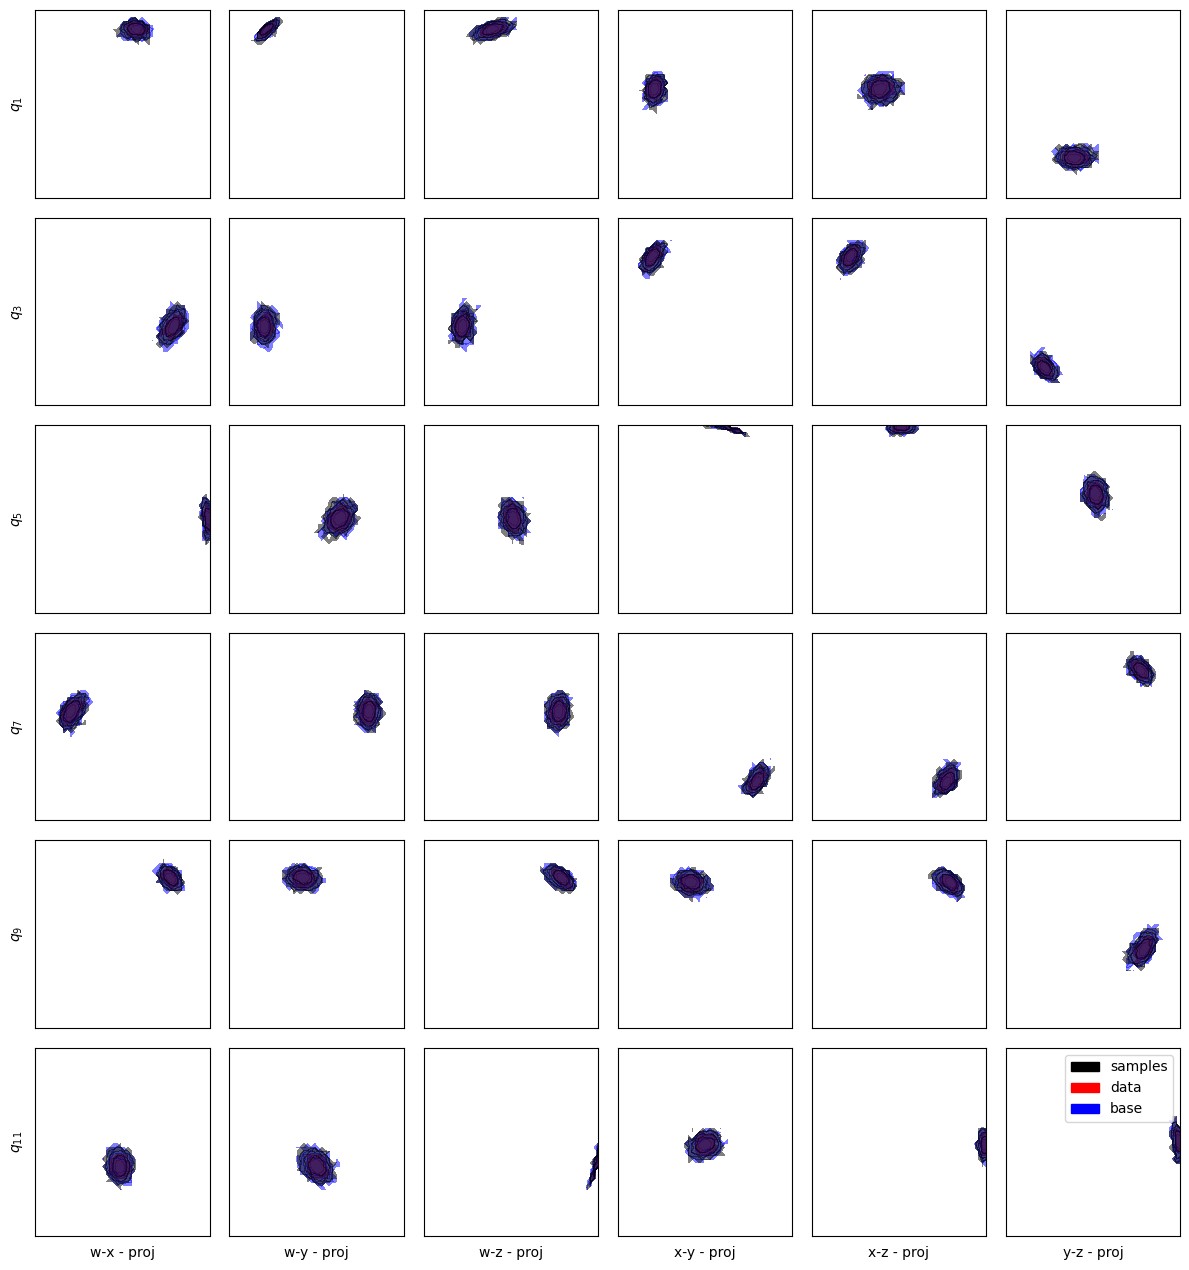

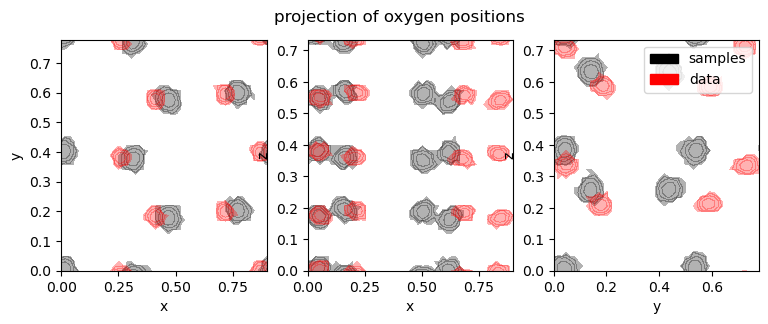

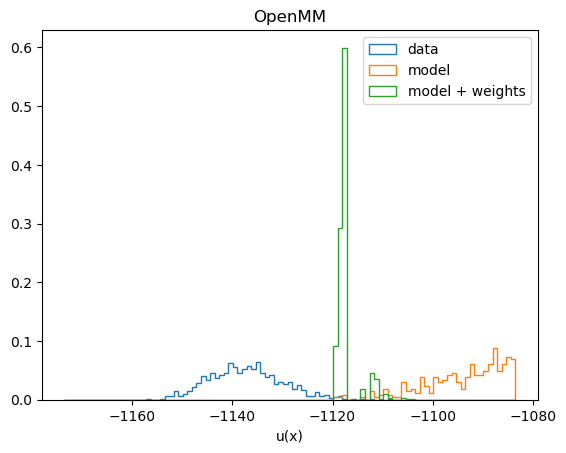

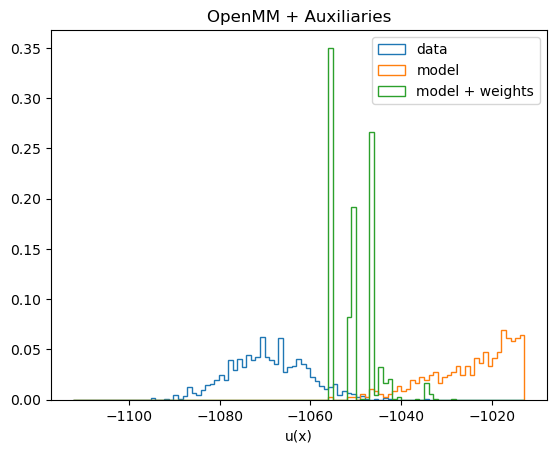

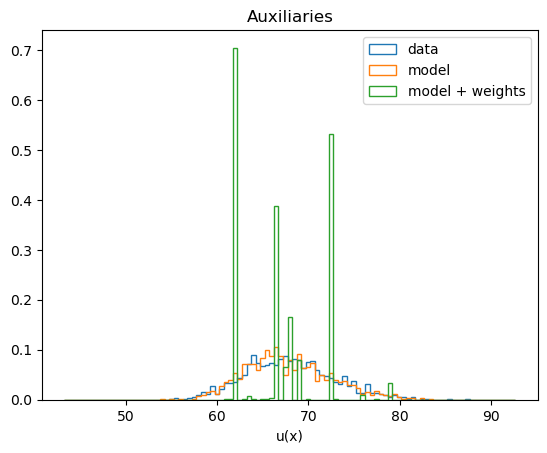

In [13]:
loss_reporter = []
flow = train(next(chain), "testing", specs, base, target, flow, tot_iter, loss_reporter)


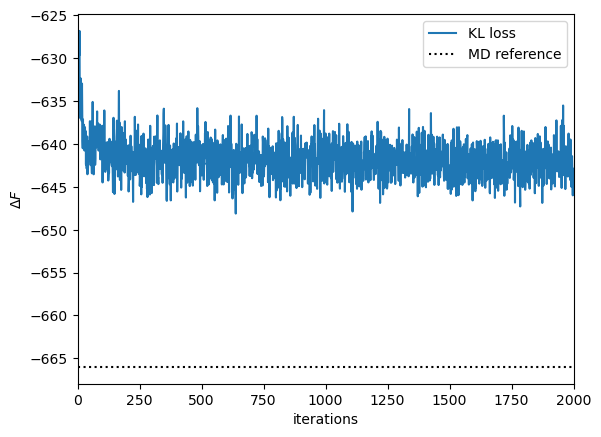

In [14]:
plt.plot(loss_reporter, label='KL loss')
plt.axhline(-666, c="k", ls=":", label='MD reference')
plt.xlim(0, len(loss_reporter))
plt.xlabel('iterations')
plt.ylabel('$\Delta F$')
plt.legend()
plt.show()


In [15]:
mapped_tr = jax.vmap(flow.inverse)(base_tr.obj)
mapped_k_oxy = jax.vmap(to_rigid)(mapped_tr.obj.pos[:, k]).obj
unsigned_bg = normalize_quats(mapped_k_oxy.rot, mapped_k_oxy.rot[0])


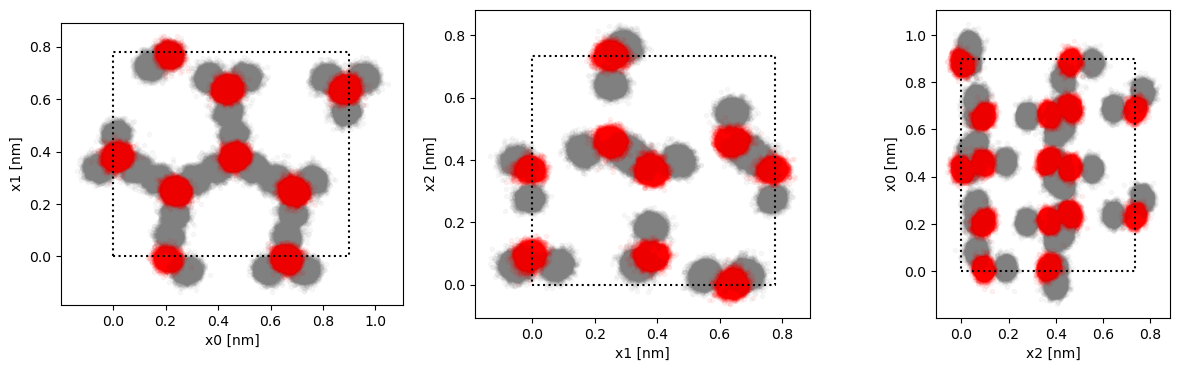

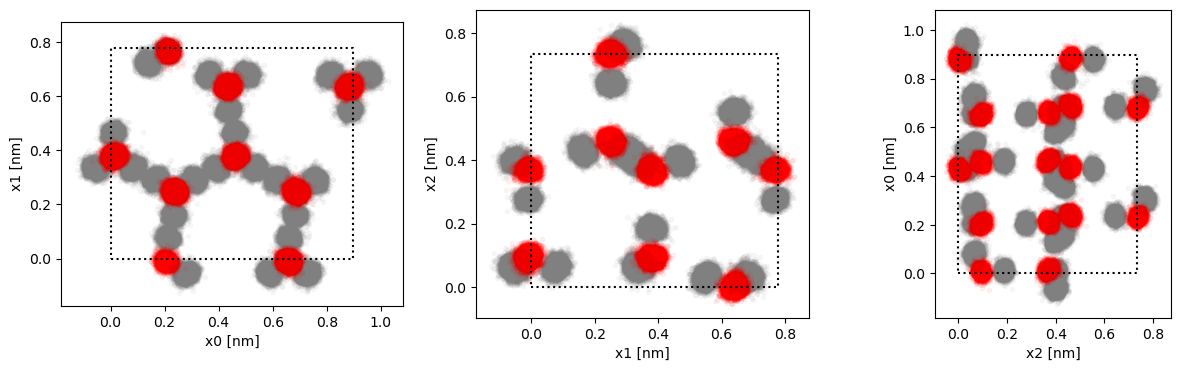

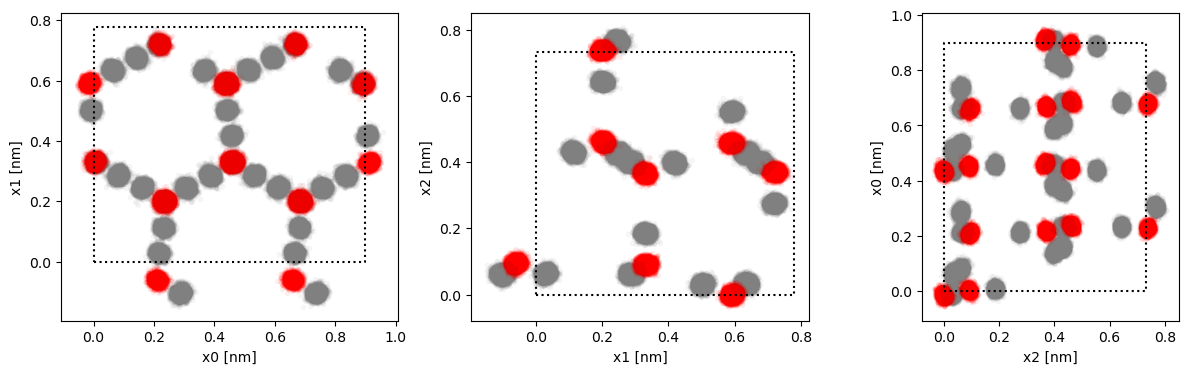

In [16]:
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))


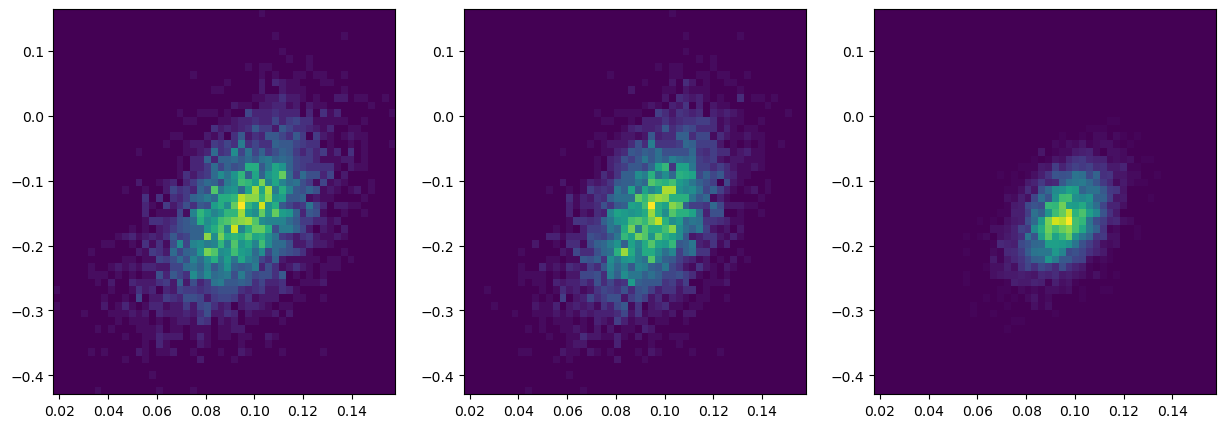

In [17]:
i = 2
j = 3
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
_, xbins, ybins, _ = plt.hist2d(base_k_oxy.pos[:, i], unsigned_base[:, j], bins=50)
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 3, 2)
plt.hist2d(mapped_k_oxy.pos[:, i], unsigned_bg[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.subplot(1, 3, 3)
plt.hist2d(target_k_oxy.pos[:, i], unsigned_target[:, j], bins=(xbins, ybins))
plt.xlim(xbins[0], xbins[-1])
plt.ylim(ybins[0], ybins[-1])

plt.show()


In [18]:
ene_fn = jax.vmap(target.potential)
base_ene = ene_fn(base_tr.obj)
mapped_ene = ene_fn(mapped_tr.obj)
target_ene = ene_fn(target_tr.obj)

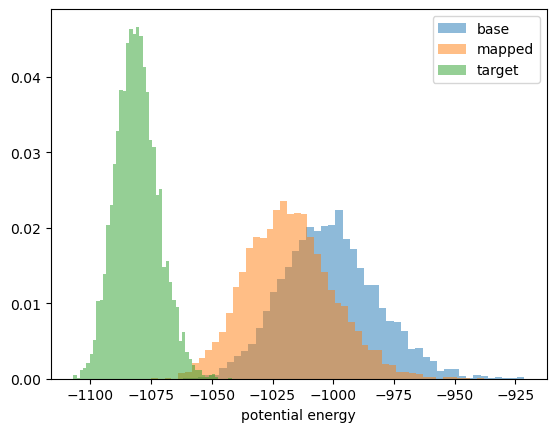

In [19]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(mapped_ene, **hist_kwargs, label='mapped')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.xlabel('potential energy')
plt.legend()
plt.show()

In [20]:
ene_label = 'com'
base_ene2 = target.compute_energies(base_tr.obj, True, True, True, True)[ene_label]
target_ene2 = target.compute_energies(target_tr.obj, True, True, True, True)[ene_label]
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, True, True, True)[ene_label]

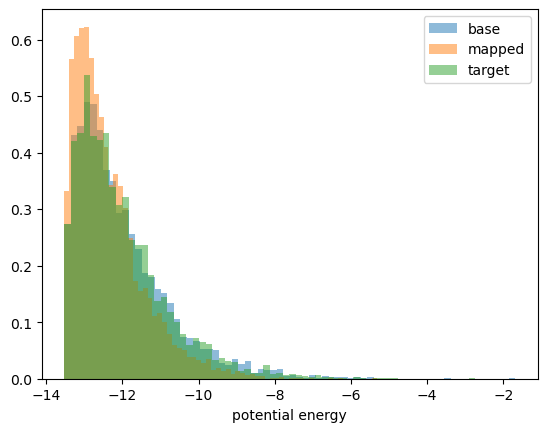

In [21]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.xlabel('potential energy')
plt.legend()
plt.show()

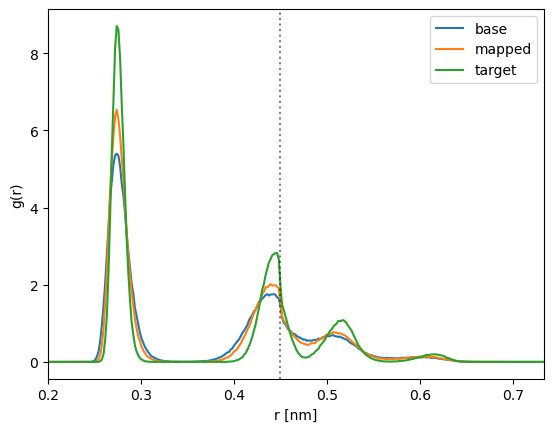

In [22]:
r_range = [0.2, np.diag(model.box).min()]
n_bins = 300
model.plot_rdf(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='base')
model.plot_rdf(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='mapped')
model.plot_rdf(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='target')
plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
plt.legend()
plt.show()

In [23]:
## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

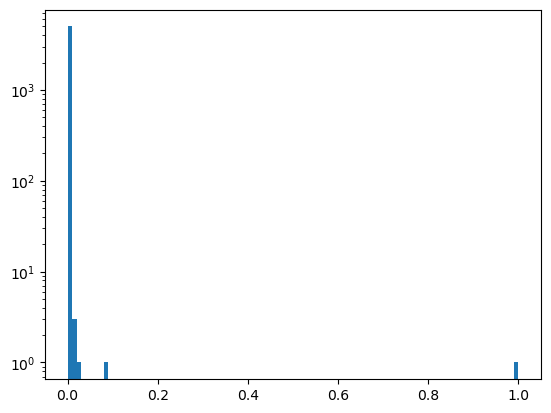

In [24]:
plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

In [25]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

ESS = 1.66165  ->  0.03%
